In [7]:
import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
from lib import plotting
import torch.nn as nn
import torch 
from torch.autograd import Variable

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [8]:
env = gym.make('Acrobot-v1')

In [9]:
class Value_model(nn.Module):

    def __init__(self):
        super(Value_model,self).__init__()
        
        # Input is observation space

        # Ouput is Q-values for each action
        
        self.model = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,env.action_space.n),
#             nn.ReLU()
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        y = torch.from_numpy(x).float()
        return self.model(y)
    
    def predict(self,x):
        pred_t = self.forward(x)
        return pred_t.clone().detach().numpy().astype(np.float64)
    
    def update(self,observation,target):
        self.optimizer.zero_grad()
        pred_t = self.forward(observation)
        targ_t = torch.from_numpy(target).float()
        targ_v = Variable(targ_t)
        loss = self.criterion(pred_t,targ_t)
#         print(loss)
        loss.backward()
        self.optimizer.step()
        


In [12]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [10]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):
        
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        action_probs = np.zeros(nA) + epsilon/(nA-1)
        action_probs[best_action] = 1.0 - epsilon
        return action_probs
    return policy_fn

In [13]:
estimator = Value_model()
policy = make_epsilon_greedy_policy(estimator, 0.1, env.action_space.n)
state = env.reset()
policy(state)

array([0.03333333, 0.93333333, 0.03333333])

In [11]:
def sarsa(env, estimator, num_episodes, discount_factor=0.99, epsilon=0.1, epsilon_decay=0.99):
    
    alpha = 1
    
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        
        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Initialize 's'
        state = env.reset()
        
        # Choose 'a' and 's' using policy derived from Q
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
        for t in itertools.count():
            
            # Take action 'a' and observe r, s'
            next_state, reward, end, _ = env.step(action)
#             reward = -reward
            env.render()
            
            # Choose a' from s' using policy derived from Q
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Get Q(s,~)
            q_values_this = estimator.predict(state)
            
            # Get Q(s',~)
            q_values_next = estimator.predict(next_state)
            
            # [r + gamma*Q(s',a')]
            td_target = alpha*(reward + discount_factor * q_values_next[next_action]) + (1-alpha)*q_values_this[action]
            
            #
            q_target = q_values_this.copy()
            q_target[action] = td_target
            
            # Update Q value
            estimator.update(state, q_target)
            
            # Policy update
#             policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
                
            if end:
                break
                
            state = next_state
            action = next_action
        if (i_episode+1) % 10 == 0:
            avg_reward = np.sum(stats.episode_rewards[max(0,i_episode-10):i_episode])/10
            print("\rEpisode {}/{} Avg. reward = {}".format(i_episode + 1, num_episodes, avg_reward))
            if avg_reward > -140.0:
                print('Training completed sucessfully!')
                break
    return stats

In [12]:
# estimator = Function_Approximator()
estimator = Value_model()

stats = sarsa(env, estimator, 500, epsilon=0.5)

Episode 10/500 Avg. reward = -450.0
Episode 20/500 Avg. reward = -500.0
Episode 30/500 Avg. reward = -500.0
Episode 40/500 Avg. reward = -487.9
Episode 50/500 Avg. reward = -298.9
Episode 60/500 Avg. reward = -272.9
Episode 70/500 Avg. reward = -233.5
Episode 80/500 Avg. reward = -288.6
Episode 90/500 Avg. reward = -215.2
Episode 100/500 Avg. reward = -145.5
Episode 110/500 Avg. reward = -143.3
Episode 120/500 Avg. reward = -169.9
Episode 130/500 Avg. reward = -131.1
Training completed sucessfully!


In [13]:
env.close()

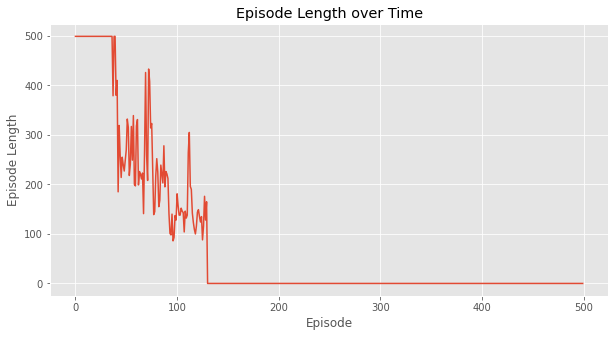

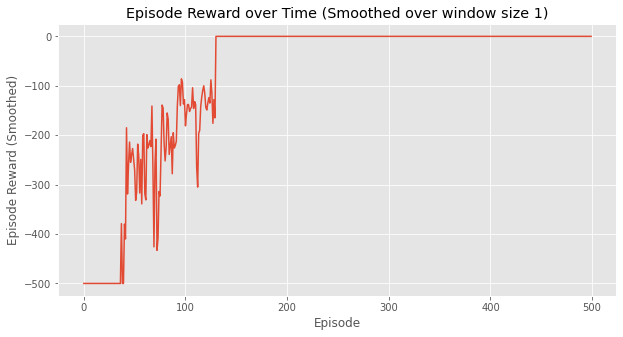

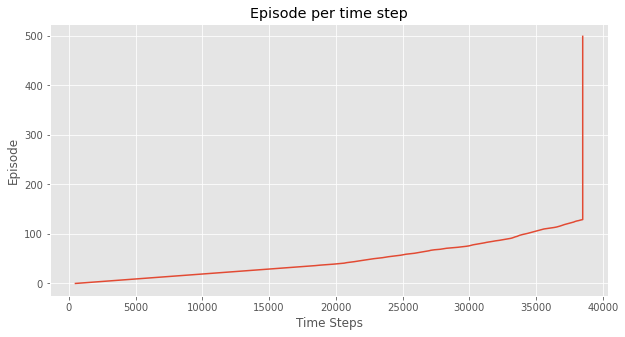

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [13]:
plotting.plot_episode_stats(stats, smoothing_window=1)

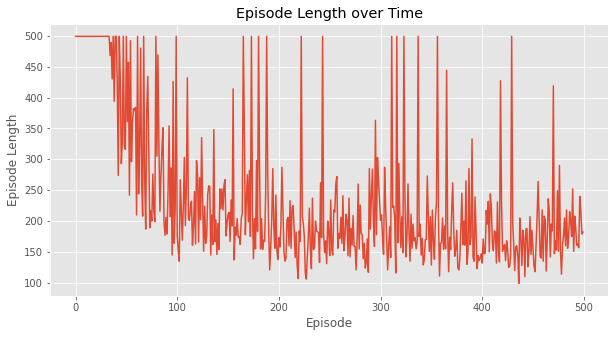

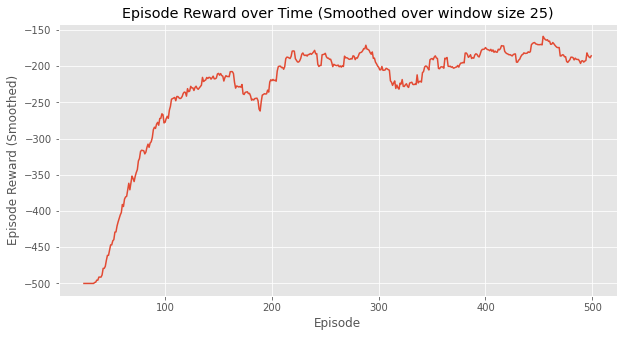

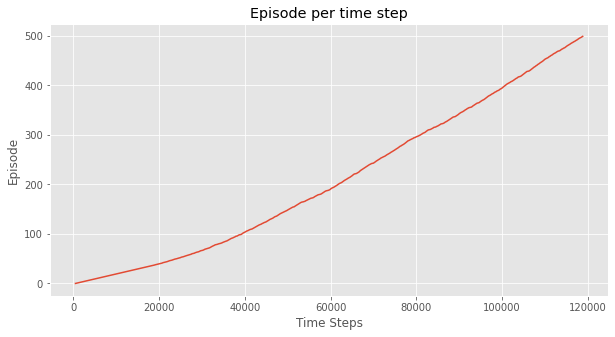

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [17]:
# state = env.observation_space.sample()
state = env.reset()
# plt.figure()
# plt.imshow(env.render(mode='rgb_array'))
while True:
    q_values = estimator.predict(state)
    best_action = np.argmax(q_values)
#     plt.figure()
#     plt.imshow(env.render(mode='rgb_array'))

#     action_pge = get_pge_action(best_action)
    
    next_state, reward, end, _ = env.step(best_action)
    if end:
        break
        
    state = next_state
    env.render()
# env.close()

In [63]:
env.observation_space.sample()

array([-0.11945403,  0.29413375, -1.4568335 , -0.17493604,  0.40899193,
        0.73602676,  1.3300323 ,  0.1892223 ], dtype=float32)

In [31]:
env = gym.make('CartPole-v1')

In [61]:
env.reset()
env.step(env.action_space.sample())

(array([ 0.00353907,  0.19214232, -0.0343606 , -0.34522076]), 1.0, False, {})

In [123]:
env.step(env.action_space.sample())

(array([-0.74117499, -1.35688824,  0.28442935,  1.79704102]), 0.0, True, {})

In [57]:
env.close()